# Cab fare prediction

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
import time
import datetime
import calendar
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import random
import pickle
random.seed(113)


from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


We have two files one for training and other for test
<ul>
 <li>train_cab.csv</li>
 <li>test_cab.csv</li>
<ul> 

In [2]:
df_train = pd.read_csv("train_cab.csv");

df_test = pd.read_csv("test.csv")

In [3]:
#Let us check the shape of dataset
print(df_train.shape)

(16067, 7)


In [4]:
#Let us check some of the data in dataframe
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
#Let us have some information about the dataframe like null values and types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [6]:
#Summing all the null values in all the columns
df_train.isnull().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

There are 55 entries in passenger_count.synthesizing the value for 55 rows in passenger count and 24 entries in fare_amount would not be great idea.So we will remove the these rows from particular dataframe

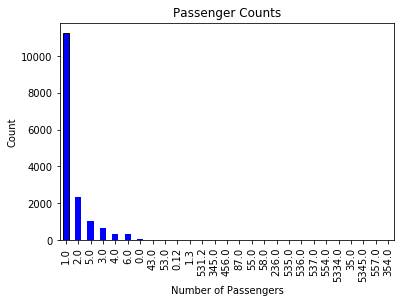

In [7]:

"""
on further analysis we have seen in most of the column passenger count in 1 so instead of dropping the rows
we can fill it with median,mean or using model like knn or we can fill with one of the frequent items
"""
# df_train = df_train.dropna(how = 'any', axis = 'rows')

df_train['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts');
plt.xlabel('Number of Passengers'); 
plt.ylabel('Count');
plt.show()

In [8]:
"""

Above graph shows that passenger_count with value 1 is occurring more frequently so we can fill it with 1
"""

df_train[['passenger_count']] = df_train[['passenger_count']].fillna(value=1)

In [9]:
df_train.isnull().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
dtype: int64

In [10]:
df_train = df_train.dropna(how = 'any', axis = 'rows')

In [11]:
print(df_train.shape)

(16043, 7)


<h5>We will start by doing some analysis on the basis of passenger_count,
which will help us to remove outlier and corrupted value</h5>

In [12]:
#As passenger count cannot be float let us convert it in integer
df_train['passenger_count'] = df_train['passenger_count'].astype(int)

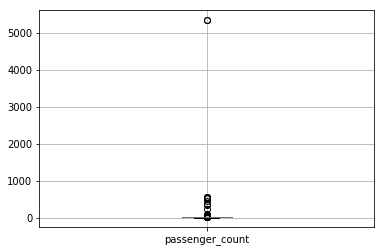

In [13]:
#checking for outliers in box plot or any corrupted data
boxplot = df_train.boxplot(column=['passenger_count'])
plt.show()

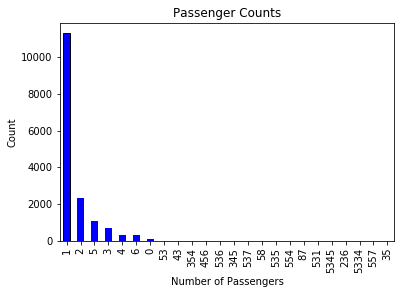

In [14]:
df_train['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts');
plt.xlabel('Number of Passengers'); 
plt.ylabel('Count');
plt.show()


As we can see in boxplot the range of data is very huge  like 5000 which is unrealistic therefore it implies that we have some corrupted data and also most of our data lies between 1 to 8 as we can see in graph above. 
<li>In reality maximum the cab can afford is 8 passenger,so we will remove all the column whcih has more than 8 passengers</li>

In [15]:
df_train = df_train.drop(df_train[df_train['passenger_count'] > 8 ].index,axis=0)

In [16]:
#Removing rows with 0 passengers as it is of no use
df_train = df_train.drop(df_train[df_train['passenger_count'] <= 0 ].index,axis=0)

In [17]:
print(df_train.shape)

(15966, 7)


<h5>Now we will do preprocessing on the basis of fare_amount

In [18]:
"""
As in dataframe information we can see fare_amount is in object/string 
so our first task is to convert the fare amount in float value then we 
will start other preprocessing
"""

df_train['fare_amount'] = df_train['fare_amount'].apply(pd.to_numeric, errors='coerce')

In [19]:
#As we have taken errors as coerce and hence row which will be having errors will be set to NaN
print(df_train.isnull().sum())

fare_amount          1
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [20]:
#We will go on removing NaN row
df_train = df_train.dropna(how = 'any', axis = 'rows')

In [21]:
print(df_train.shape)

(15965, 7)


In [22]:
#Also fare_amount cannot be negative or zero and hence remove all the rows having fare_amount as zero or negative
df_train = df_train.drop(df_train[df_train['fare_amount'] <= 0 ].index,axis=0)

In [23]:
print(df_train.shape)

(15961, 7)


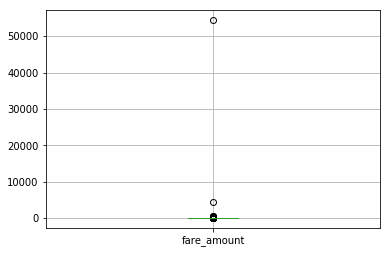

In [24]:
#checking for outliers in box plot or any corrupted data
boxplot = df_train.boxplot(column=['fare_amount'])
plt.show()
  


We can see there are some data which are more than 50000 in boxplot graph.Let us see how many rows we have that has fare_amount more than 5000 and further we will take random fare amount and explore where most of our data lies. as most of the point lies inside 5000


In [25]:
print(len(df_train[df_train['fare_amount']<5000]))
print(len(df_train[df_train['fare_amount']<1000]))
print(len(df_train[df_train['fare_amount']<500]))
print(len(df_train[df_train['fare_amount']<100]))

15960
15959
15959
15952


In [26]:
"""
As most of our data lies less than 100 we will remove all the rows fare_amount more than 100 whcih will surely help
our model
"""
df_train = df_train.drop(df_train[df_train['fare_amount'] > 100 ].index,axis=0)

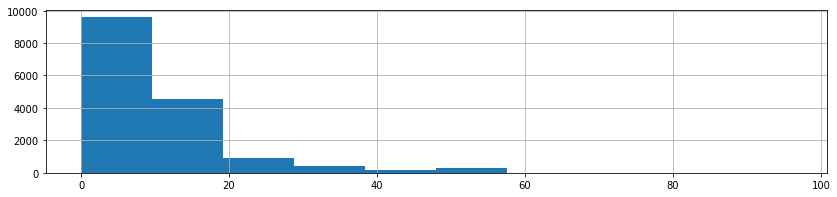

In [27]:
df_train[df_train['fare_amount']<100].fare_amount.hist(bins=10, figsize=(14,3))
plt.show()


In [28]:
# we will also remove some values which are not zero but close to zero
df_train[df_train['fare_amount'] < 1 ]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2780,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1


In [29]:
df_train = df_train.drop(df_train[df_train['fare_amount'] < 1 ].index,axis=0)

In [30]:
print(df_train.shape)

(15951, 7)


In [31]:
df_train.head(20)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
9,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2
10,5.3,2012-04-08 07:30:50 UTC,-73.996335,40.737142,-73.980721,40.733559,1


As we can see we also have some values in which all the pickup latitude and lattude  are 0 which means they are corrupted so we will remove all the data with all the 4 attributes with 0 values

In [32]:
df_train = df_train.drop(df_train[
    (df_train['pickup_longitude'] == 0) 
    & (df_train['pickup_latitude'] == 0) 
    & (df_train['dropoff_longitude'] == 0) 
    & (df_train['dropoff_latitude'] == 0 )
].index, axis=0)
print(df_train.shape)

(15653, 7)


In [33]:
#Some of the research has given me a values in which lattitude and longitude lies
#Lattitude Lie between -90 to  90
#Longitude Lie between -180 to 180
df_train[
    (df_train['pickup_longitude'] > 180) 
    |  (df_train['pickup_longitude'] < -180) 
    | (df_train['pickup_latitude'] > 90) 
    | (df_train['pickup_latitude'] < -90) 
    | (df_train['dropoff_longitude'] > 180 )
    | (df_train['dropoff_longitude'] < -180 )
    | (df_train['dropoff_latitude'] > 90) 
    | (df_train['dropoff_latitude'] < -90)
]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
5686,3.3,2011-07-30 11:15:00 UTC,-73.947235,401.083332,-73.951392,40.778927,1


In [34]:
#As the above data is correct we have some weird value for pickup we can remove this data

df_train = df_train.drop(df_train[
    (df_train['pickup_longitude'] > 180) 
    |  (df_train['pickup_longitude'] < -180) 
    | (df_train['pickup_latitude'] > 90) 
    | (df_train['pickup_latitude'] < -90) 
    | (df_train['dropoff_longitude'] > 180 )
    | (df_train['dropoff_longitude'] < -180 )
    | (df_train['dropoff_latitude'] > 90) 
    | (df_train['dropoff_latitude'] < -90)
].index , axis=0)


print(df_train.shape)

(15652, 7)


As we have Latitude and longitude there must be some way we can calulate the distance travelled,Found following formulae on calculating distance from latitudes and longitudes
https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

In [35]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [36]:
 df_train['haversine_distance'] = df_train.apply(lambda row : sphere_dist(row['pickup_latitude']
                                                            ,row['pickup_longitude'],
                                                            row['dropoff_latitude'],
                                                            row['dropoff_longitude'])
                                                           , axis = 1)

In [37]:
df_train = df_train.drop(df_train[
    (df_train['haversine_distance'] == 0)].index , axis=0)



In [38]:
 df_train[df_train['haversine_distance'] >100 ]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance
472,2.50,2009-02-22 22:48:00 UTC,0.000000,0.000000,-74.005433,40.726685,2,8667.304968
1260,5.70,2011-03-10 20:25:00 UTC,-73.973907,40.754743,0.000000,0.000000,2,8665.268588
2280,8.90,2011-08-29 08:24:00 UTC,-73.936667,40.757815,0.000000,40.757815,1,6026.494216
2397,45.00,2012-06-24 17:11:10 UTC,0.000000,0.000000,-74.010230,40.714553,2,8667.454421
4278,7.00,2015-04-07 23:33:02 UTC,-73.972702,40.757423,0.000000,0.000000,1,8665.223767
4597,6.90,2010-03-30 07:12:00 UTC,0.000000,0.000000,-73.989693,40.754280,1,8666.566030
5663,49.15,2009-02-25 07:05:05 UTC,-73.137393,41.366138,-74.000940,40.731723,1,101.094619
5864,8.50,2012-03-04 01:35:00 UTC,-73.995030,40.744945,-7.986640,40.729937,1,5420.988959
6188,15.50,2014-07-28 15:04:00 UTC,0.000000,0.000000,-73.952980,40.786670,5,8664.191488
6302,16.50,2015-02-27 16:18:58 UTC,0.000000,0.000000,-73.936600,40.796543,1,8663.039123


In [39]:
#As we can see there are still some values which are huge so we can drop it
df_train = df_train.drop(df_train[
    (df_train['pickup_longitude'] == 0) 
    |  (df_train['pickup_longitude'] == 0) 
    | (df_train['pickup_latitude'] == 0) 
    | (df_train['pickup_latitude'] == 0) 
    | (df_train['dropoff_longitude'] == 0 )
    | (df_train['dropoff_longitude'] ==  0 )
    | (df_train['dropoff_latitude'] == 0) 
    | (df_train['dropoff_latitude'] == 0)
].index, axis= 0)


In [40]:
df_train[df_train['haversine_distance'] > 50 ].shape

(13, 8)

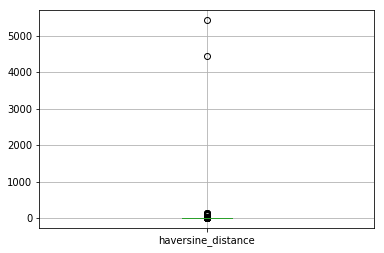

1
2
2
13


(13, 8)

In [41]:
boxplot = df_train.boxplot(column=['haversine_distance'])
plt.show()

print(len(df_train[df_train['haversine_distance']>5000]))
print(len(df_train[df_train['haversine_distance']>1000]))
print(len(df_train[df_train['haversine_distance']>500]))
print(len(df_train[df_train['haversine_distance'] > 50]))


df_train[df_train['haversine_distance'] > 50].sort_values("haversine_distance",ascending=False)

df_train[df_train['haversine_distance'] > 50].shape

# df_train = df_train.drop(df_train[
#     (df_train['haversine_distance'] > 100)].index , axis=0)
# df_train[df_train['haversine_distance']<100].haversine_distance(bins=10, figsize=(14,3))

In [42]:
df_train[df_train['haversine_distance'] < 50].sort_values("haversine_distance",ascending=False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance
649,66.30,2009-09-19 10:34:41 UTC,-74.438233,40.993260,-74.185996,40.693874,2,39.476975
6308,45.00,2010-08-23 11:06:00 UTC,-73.422692,40.747012,-73.870317,40.773160,1,37.812945
4118,69.70,2011-08-13 17:49:36 UTC,-73.776700,40.645400,-73.905900,40.921800,1,32.602535
7021,56.50,2011-06-21 16:22:00 UTC,-73.782140,40.644682,-73.847187,40.905170,2,29.478280
6677,49.57,2010-04-18 23:57:00 UTC,-73.782228,40.644710,-73.930560,40.853538,1,26.369072
4567,10.10,2010-01-07 11:52:00 UTC,-73.989795,40.715727,-73.996540,40.484335,1,25.735917
8105,55.00,2014-08-29 02:35:00 UTC,-74.008680,40.704042,-73.868047,40.898910,5,24.690884
15023,73.30,2011-08-31 07:17:00 UTC,-73.866952,40.771788,-73.587587,40.724017,2,24.125745
15178,49.57,2010-11-03 18:06:00 UTC,-73.783893,40.648630,-73.948913,40.822512,1,23.814940
14099,57.33,2013-11-06 12:34:45 UTC,-73.776687,40.645300,-73.958122,40.808114,1,23.696200


With some analysis on haversine distance we have found some haversine distance is very huge there is also low fare amount for some haversine ditance whcih are greater than 50 so we canremove all the rows which have haversine distance more than 50 and we have 13 rows like that 
<li>Fare can be low for high distance because of mistake in data collection</li>
<li>One of the possibilty that the fare is low is because of some coupons or scheme</li>


In [43]:
df_train = df_train.drop(df_train[df_train['haversine_distance'] > 50 ].index,axis=0)

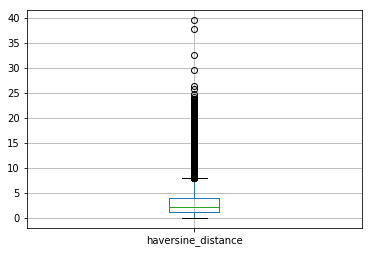

In [44]:

boxplot = df_train.boxplot(column=['haversine_distance'])
plt.show()

In [45]:
df_train.shape

(15464, 8)

In [46]:
df_train.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
5,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,3.787239
6,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,1.555807
7,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,4.155444
9,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,2.849627
10,5.3,2012-04-08 07:30:50 UTC,-73.996335,40.737142,-73.980721,40.733559,1,1.374577


In [47]:
"""
Also converting latitudes and longitudes to radians
"""
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree)
df_train['pickup_longitude']  = radian_conv(df_train['pickup_longitude'])
df_train['pickup_latitude']  = radian_conv(df_train['pickup_latitude'])
df_train['dropoff_longitude']  = radian_conv(df_train['dropoff_longitude'])
df_train['dropoff_latitude']  = radian_conv(df_train['dropoff_latitude'])

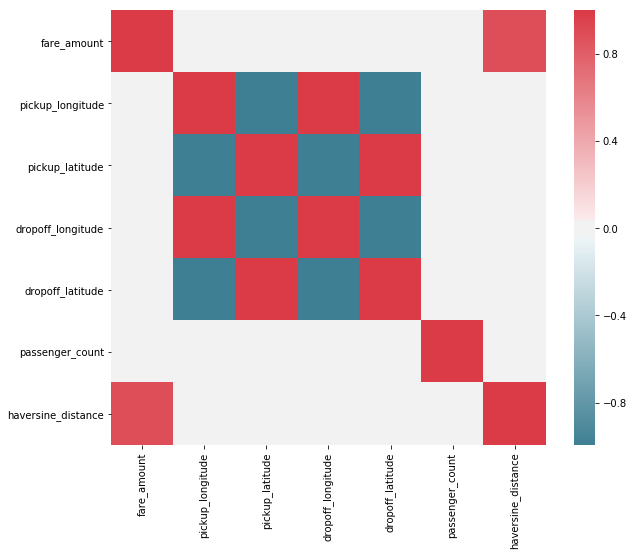

In [48]:
f, ax = plt.subplots(figsize=(10, 8))
corr =df_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

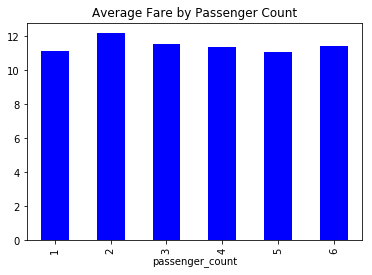

In [49]:
df_train.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');
plt.show()

We can see some changes in passenger count which is small so we will select it to feed in model

In [50]:
# splitting data in to test and train
train, test = train_test_split(df_train, test_size=0.2)
    

In [51]:
print("train data shape",train.shape)
print("test data shape",test.shape)

train data shape (12371, 8)
test data shape (3093, 8)


In [52]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance
10554,10.1,2012-03-06 12:11:54 UTC,-1.291635,0.710742,-1.291303,0.711171,1,3.168433
10752,12.1,2010-06-02 06:44:35 UTC,-1.291280,0.710731,-1.291093,0.711439,1,4.599732
4094,6.1,2009-05-18 08:38:00 UTC,-1.290981,0.711403,-1.290699,0.711617,2,1.927532
13711,24.0,2014-03-18 14:41:00 UTC,-1.291263,0.711589,-1.291671,0.710460,1,7.456466
12171,6.1,2010-06-03 17:31:38 UTC,-1.291353,0.711190,-1.291268,0.711382,1,1.285383


In [53]:
X_train  = train.drop(['fare_amount','pickup_datetime'], axis=1)

Y_train = train[['fare_amount']]


X_test  = test.drop(['fare_amount','pickup_datetime'], axis=1)

Y_test = test[['fare_amount']]

In [54]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance
10554,-1.291635,0.710742,-1.291303,0.711171,1,3.168433
10752,-1.291280,0.710731,-1.291093,0.711439,1,4.599732
4094,-1.290981,0.711403,-1.290699,0.711617,2,1.927532
13711,-1.291263,0.711589,-1.291671,0.710460,1,7.456466
12171,-1.291353,0.711190,-1.291268,0.711382,1,1.285383


In [55]:
Y_train.head()

,fare_amount
10554,10.1
10752,12.1
4094,6.1
13711,24.0
12171,6.1


In [56]:
def linear_regression(x_train,y_train,x_test,y_test):
    regressor = LinearRegression()  
    regressor = regressor.fit(x_train, y_train) #training the algorithm
    y_pred = regressor.predict(x_train)
    rmse_train =  sqrt(mean_squared_error(y_train, y_pred))
#     print("rmse for simple linear regression for train data",rmse_train)
    y_pred_test = regressor.predict(x_test)
    rmse_test =  sqrt(mean_squared_error(y_test, y_pred_test))
    
   
    SS_Residual = sum((y_test.values-y_pred_test)**2)
    
   
    SS_Total = sum((y_test.values-np.mean(y_test.values))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    print("R squared",r_squared) 
    print("adjusted r square",adjusted_r_squared)
    #
#     print("rmse for simple linear regression for test data",rmse_test)
    return {'rmse_train':rmse_train,'rmse_test':rmse_test}

In [57]:
def decision_trees(x_train,y_train,x_test,y_test):
    clf =  DecisionTreeRegressor(random_state = 0)
    clf = clf.fit(x_train, y_train)
    y_pred_tree = clf.predict(x_train)
    rmse_train =  sqrt(mean_squared_error(y_train, y_pred_tree))
#     print("rmse for decision trees for train data",rmse)
    y_pred_tree_test = clf.predict(x_test)
    rmse_test =  sqrt(mean_squared_error(y_test,y_pred_tree_test))
    
# #for rsquare and adjusted
#     SS_Residual = sum((y_test.values-y_pred_tree_test)**2)
    
   
#     SS_Total = sum((y_test.values-np.mean(y_test.values))**2)
#     r_squared = 1 - (float(SS_Residual))/SS_Total
#     adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
#     print("R squared",r_squared) 
#     print("adjusted r square",adjusted_r_squared)


# ##############
    
#     print("rmse for decision trees for test data",rmse)
    
    return {'rmse_train':rmse_train,'rmse_test':rmse_test}


In [58]:

    

def random_forest_model(x_train,y_train,x_test,y_test,depth):
#     print(depth)
    regr = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=100)
    regr = regr.fit(X_train,Y_train)
    feature_importances = pd.DataFrame({'feature': X_train.columns,
                                        'importance': regr.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
                           
    y_pred_tree_random_forest = regr.predict(X_train)
    rmse_train =  sqrt(mean_squared_error(Y_train, y_pred_tree_random_forest))
#     print("rmse of Random trees for train data for dpth {} is {}".format(diff_depths[i],rmse))
    y_pred_tree_test_random = regr.predict(X_test)
    rmse_test =  sqrt(mean_squared_error(Y_test,y_pred_tree_test_random))
    
    #for rsquare and adjusted
#     SS_Residual = sum((y_test.values-y_pred_tree_test_random)**2)
    
   
#     SS_Total = sum((y_test.values-np.mean(y_test.values))**2)
#     r_squared = 1 - (float(SS_Residual))/SS_Total
#     adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
#     print("R squared",r_squared) 
#     print("adjusted r square",adjusted_r_squared)


##############
#     print("rmse of Random trees for test data for depth {} is {}".format(diff_depths[i],rmse))
#     print(feature_importances.head(10))
    
    return {'rmse_train':rmse_train,'rmse_test':rmse_test}
        
        
    

In [59]:
linear_regression_rmse = linear_regression(X_train,Y_train,X_test,Y_test)

print("linear_regression",linear_regression_rmse)

R squared [ 0.75661269]
adjusted r square [ 0.75613948]
linear_regression {'rmse_train': 4.305475047206284, 'rmse_test': 4.3898127412154855}


In [60]:
decision_trees_rmse = decision_trees(X_train,Y_train,X_test,Y_test)
print("decison trees",decision_trees_rmse)

decison trees {'rmse_train': 2.5829473209345894e-16, 'rmse_test': 5.491155187149884}


In [61]:
def knn_model(x_train,y_train,x_test,y_test,n):
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh = neigh.fit(X_train,Y_train)
    y_pred_tree_knn = neigh.predict(X_train)
    rmse_train =  sqrt(mean_squared_error(Y_train,y_pred_tree_knn))
#     print("rmse of knn for train data for {} neighbour is {}".format(diff_neighbours[i],rmse))
    y_pred_knn_test = neigh.predict(X_test)
    rmse_test =  sqrt(mean_squared_error(Y_test,y_pred_knn_test))
    
    
     #for rsquare and adjusted
#     SS_Residual = sum((y_test.values-y_pred_knn_test)**2)
    
   
#     SS_Total = sum((y_test.values-np.mean(y_test.values))**2)
#     r_squared = 1 - (float(SS_Residual))/SS_Total
#     adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
#     print("R squared",r_squared) 
#     print("adjusted r square",adjusted_r_squared)


##############
    
    
    
    
    return {'rmse_train':rmse_train,'rmse_test':rmse_test}
#     print("rmse of knn for test data for {} neighbour is {}".format(diff_neighbours[i],rmse))

    
    
def knn(x_train,y_train,x_test,y_test):    
    diff_neighbours = [1,2,3,4,5,6,7,8,9]
    for i in range(0,len(diff_neighbours)):
        rmse_errors = knn_model(x_train,y_train,x_test,y_test,diff_neighbours[i])
        
        print("rmse of knn  for train data for dpth {} is {}".format(diff_neighbours[i],rmse_errors['rmse_train']))
        print("rmse of knn  for test data for dpth {} is {}".format(diff_neighbours[i],rmse_errors['rmse_test']))
        
    

In [62]:
knn(X_train,Y_train,X_test,Y_test)

rmse of knn  for train data for dpth 1 is 0.0
rmse of knn  for test data for dpth 1 is 6.234897773218341
rmse of knn  for train data for dpth 2 is 2.9338587481730727
rmse of knn  for test data for dpth 2 is 5.3311024217358485
rmse of knn  for train data for dpth 3 is 3.3965643816910798
rmse of knn  for test data for dpth 3 is 4.940187832965578
rmse of knn  for train data for dpth 4 is 3.614569928878702
rmse of knn  for test data for dpth 4 is 4.742713449071793
rmse of knn  for train data for dpth 5 is 3.7234523718282775
rmse of knn  for test data for dpth 5 is 4.644750538561831
rmse of knn  for train data for dpth 6 is 3.8077028446223986
rmse of knn  for test data for dpth 6 is 4.561616777083766
rmse of knn  for train data for dpth 7 is 3.855249301834905
rmse of knn  for test data for dpth 7 is 4.506745662362621
rmse of knn  for train data for dpth 8 is 3.9227557135702127
rmse of knn  for test data for dpth 8 is 4.460770143778132
rmse of knn  for train data for dpth 9 is 3.960449867574

In [63]:
def random_forest(x_train,y_train,x_test,y_test):
    diff_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    
    for i in range(0,len(diff_depths)):
#         print(diff_depths[i])   
        rmse_errors = random_forest_model(x_train,y_train,x_test,y_test,diff_depths[i])
        
        print("rmse of Random trees for train data for dpth {} is {}".format(diff_depths[i],rmse_errors['rmse_train']))
        print("rmse of Random trees for test data for dpth {} is {}".format(diff_depths[i],rmse_errors['rmse_test']))


    return

random_forest(X_train,Y_train,X_test,Y_test)

rmse of Random trees for train data for dpth 1 is 6.1552928774488525
rmse of Random trees for test data for dpth 1 is 5.880602651443008
rmse of Random trees for train data for dpth 2 is 4.633121045961094
rmse of Random trees for test data for dpth 2 is 4.609027130802391
rmse of Random trees for train data for dpth 3 is 4.208404487113696
rmse of Random trees for test data for dpth 3 is 4.255256950844741
rmse of Random trees for train data for dpth 4 is 3.898838789281258
rmse of Random trees for test data for dpth 4 is 4.06598229235376
rmse of Random trees for train data for dpth 5 is 3.665078100089843
rmse of Random trees for test data for dpth 5 is 3.9622873767862385
rmse of Random trees for train data for dpth 6 is 3.482521370343845
rmse of Random trees for test data for dpth 6 is 3.9310844274353345
rmse of Random trees for train data for dpth 7 is 3.2872179237166135
rmse of Random trees for test data for dpth 7 is 3.937841133445287
rmse of Random trees for train data for dpth 8 is 3.


<h3>We can take few insights from these regressions</h3>
<ul>
<li>1.Simple Linear regression has performed well but not so well that we can use this in prediction.</li>
<li>2.RMSE for decision trees for test data is higher than that of test data and hence we can say our decision tree has overfit.</li>
<li>3.Random forest has performed very well on this data and its rmse for train and test both are low and hence
we can use Random forest in production for this model.</li>
<li>4.KNN has performed also well on this data but not as good as random forest and hence we will freeze random forest to be use for production.</li>
<ul>

Let us do some feature engineering by adding some new features
and after that we will look at our model performance


As we know cab fare besides from passenger and distance also depends upon some factors like weekends,festival season,pickup hour or more let us use the pickup datetime feature so we could explore more about that

<li>People more likely to go office on weekdays rather on weekends</li>
<li>Most of the people in real go to office in morning rather in night</li>

In [64]:
#Formatting the picup daytime so we could split it in hour, day, week and year
df_train['pickup_datetime']=pd.to_datetime(df_train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC', errors='coerce')

In [65]:
df_train.isnull().sum()

fare_amount           0
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
haversine_distance    0
dtype: int64

In [66]:
df_train = df_train.dropna(how = 'any', axis = 'rows')

In [67]:
df_train.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
haversine_distance    0
dtype: int64

In [68]:
#We make columns for day,hour ,week,year
df_train['pickup_date']= df_train['pickup_datetime'].dt.date
df_train['pickup_day']=df_train['pickup_datetime'].apply(lambda x:x.day)
df_train['pickup_hour']=df_train['pickup_datetime'].apply(lambda x:x.hour)
df_train['pickup_day_of_week']=df_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
df_train['pickup_month']=df_train['pickup_datetime'].apply(lambda x:x.month)
df_train['pickup_year']=df_train['pickup_datetime'].apply(lambda x:x.year)

In [69]:
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,2009-06-15 17:26:21,-1.288826,0.710721,-1.288779,0.710563,1,1.030764,2009-06-15,15,17,Monday,6,2009
1,16.9,2010-01-05 16:52:16,-1.291824,0.710546,-1.291182,0.711780,1,8.450134,2010-01-05,5,16,Tuesday,1,2010
2,5.7,2011-08-18 00:35:00,-1.291242,0.711418,-1.291391,0.711231,2,1.389525,2011-08-18,18,0,Thursday,8,2011
3,7.7,2012-04-21 04:30:42,-1.291319,0.710927,-1.291396,0.711363,1,2.799270,2012-04-21,21,4,Saturday,4,2012
4,5.3,2010-03-09 07:51:00,-1.290987,0.711536,-1.290787,0.711811,1,1.999157,2010-03-09,9,7,Tuesday,3,2010


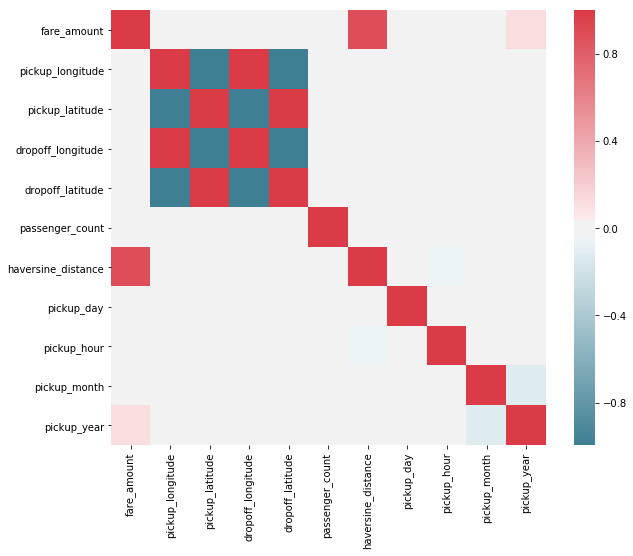

In [70]:
f, ax = plt.subplots(figsize=(10, 8))
corr =df_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

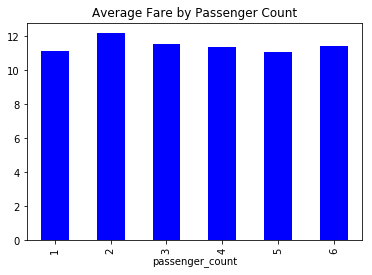

In [71]:
df_train.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');
plt.show()

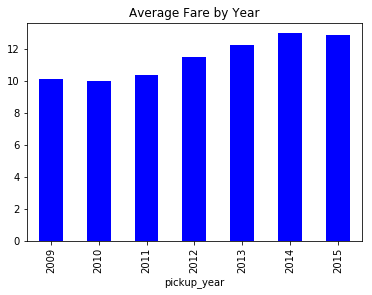

In [72]:
df_train.groupby('pickup_year')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Year');
plt.show()

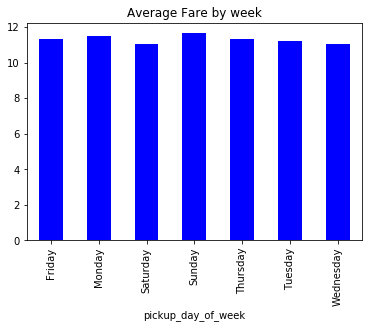

In [73]:
df_train.groupby('pickup_day_of_week')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by week');
plt.show()



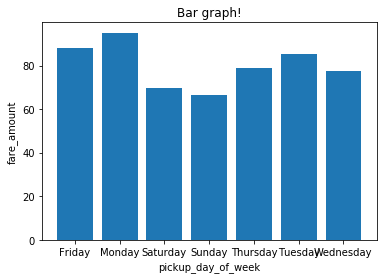

In [74]:
plt.bar(df_train['pickup_day_of_week'], df_train['fare_amount'],  width = 0.8) 

# naming the x-axis 
plt.xlabel('pickup_day_of_week') 
# naming the y-axis 
plt.ylabel('fare_amount') 
# plot title 
plt.title('Bar graph!')
plt.show()


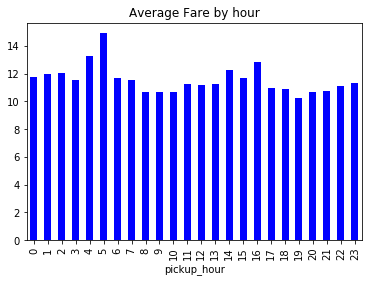

In [75]:
df_train.groupby('pickup_hour')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by hour');
plt.show()

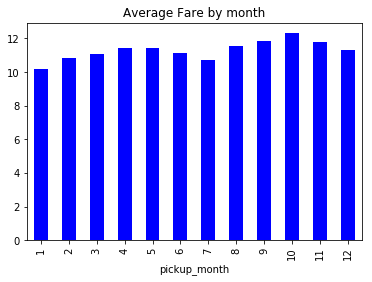

In [76]:
df_train.groupby('pickup_month')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by month');
plt.show()

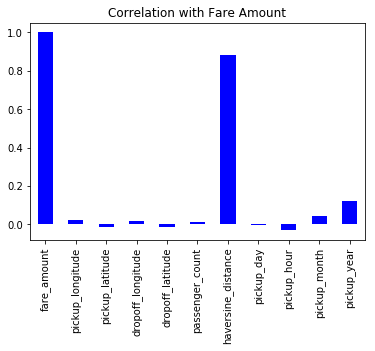

In [77]:
corrs = df_train.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');
plt.show()

From above analysis we can observe that

<li>Fare amount increases every year so it one of the variable whcih can help our model to  perform better</li>
<li>Far amount in some pickup hour is more as compare to others so it could also help our model to perform better</li>
<li>Fare amount is greater on some days as compared to others</li>


In [78]:
#Let us first convert the pickup_day_of_week in to numerical variable as it is categorical variable
# cat_columns = ['pickup_day_of_week']
# df_train = pd.get_dummies(df_train, prefix_sep="__",
#                               columns=cat_columns)
# df_train = pd.get_dummies(df_train, prefix_sep="__",
#                               columns=['pickup_month'])
# df_train = pd.get_dummies(df_train, prefix_sep="__",
#                               columns=['pickup_hour'])

In [79]:
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,2009-06-15 17:26:21,-1.288826,0.710721,-1.288779,0.710563,1,1.030764,2009-06-15,15,17,Monday,6,2009
1,16.9,2010-01-05 16:52:16,-1.291824,0.710546,-1.291182,0.711780,1,8.450134,2010-01-05,5,16,Tuesday,1,2010
2,5.7,2011-08-18 00:35:00,-1.291242,0.711418,-1.291391,0.711231,2,1.389525,2011-08-18,18,0,Thursday,8,2011
3,7.7,2012-04-21 04:30:42,-1.291319,0.710927,-1.291396,0.711363,1,2.799270,2012-04-21,21,4,Saturday,4,2012
4,5.3,2010-03-09 07:51:00,-1.290987,0.711536,-1.290787,0.711811,1,1.999157,2010-03-09,9,7,Tuesday,3,2010


In [80]:
"""
We can split our data in 80:20
where 80% data will be our training data and 20% data will be our test data
"""
train, test = train_test_split(df_train, test_size=0.2)

In [81]:
train.shape

(12370, 14)

In [82]:
test.shape

(3093, 14)

In [83]:
X_train  = train.drop(['fare_amount','pickup_datetime','pickup_date','pickup_day','pickup_day_of_week'
                      ], axis=1)

In [84]:
Y_train = train[['fare_amount']]

In [85]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_hour,pickup_month,pickup_year
12468,-1.291521,0.711048,-1.291355,0.711143,1,1.001352,17,4,2014
11310,-1.291037,0.711964,-1.291127,0.711762,1,1.353084,13,3,2011
12985,-1.291161,0.710789,-1.291329,0.710721,1,0.918470,2,2,2015
4380,-1.291108,0.711346,-1.290968,0.711203,1,1.130103,12,7,2011
5428,-1.291254,0.711514,-1.291490,0.711087,2,2.946909,3,4,2010


In [86]:
Y_train.head()

,fare_amount
12468,5.0
11310,4.9
12985,5.5
4380,6.5
5428,6.9


In [87]:
X_test  = test.drop(['fare_amount','pickup_datetime','pickup_date','pickup_day','pickup_day_of_week'
                      ] ,axis=1)
Y_test = test[['fare_amount']]

In [88]:
Y_train.shape

(12370, 1)

In [89]:
linear_regression_rmse = linear_regression(X_train,Y_train,X_test,Y_test)

print("linear_regression",linear_regression_rmse)

R squared [ 0.83283345]
adjusted r square [ 0.83234545]
linear_regression {'rmse_train': 4.306477176690858, 'rmse_test': 3.79999003671382}


In [90]:
decision_trees_rmse = decision_trees(X_train,Y_train,X_test,Y_test)
print("decison trees",decision_trees_rmse)

decison trees {'rmse_train': 1.2550390819707792e-15, 'rmse_test': 4.554447945463919}


In [91]:
# def random_forest(x_train,y_train,x_test,y_test):
#     diff_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    
#     for i in range(0,len(diff_depths)):
# #         print(diff_depths[i])   
#         rmse_errors = random_forest_model(x_train,y_train,x_test,y_test,diff_depths[i])
        
#         print("rmse of Random trees for train data for dpth {} is {}".format(diff_depths[i],rmse_errors['rmse_train']))
#         print("rmse of Random trees for test data for dpth {} is {}".format(diff_depths[i],rmse_errors['rmse_test']))


#     return

random_forest(X_train,Y_train,X_test,Y_test)

rmse of Random trees for train data for dpth 1 is 6.158220300173927
rmse of Random trees for test data for dpth 1 is 5.981222783702355
rmse of Random trees for train data for dpth 2 is 4.6888577341360484
rmse of Random trees for test data for dpth 2 is 4.335925068741196
rmse of Random trees for train data for dpth 3 is 4.2568856670384765
rmse of Random trees for test data for dpth 3 is 3.861911098153241
rmse of Random trees for train data for dpth 4 is 3.926959094468337
rmse of Random trees for test data for dpth 4 is 3.6573896741576024
rmse of Random trees for train data for dpth 5 is 3.6604201483088303
rmse of Random trees for test data for dpth 5 is 3.50017921693251
rmse of Random trees for train data for dpth 6 is 3.420898843957848
rmse of Random trees for test data for dpth 6 is 3.383228787388838
rmse of Random trees for train data for dpth 7 is 3.186216187269423
rmse of Random trees for test data for dpth 7 is 3.3331244538250875
rmse of Random trees for train data for dpth 8 is 2

In [92]:
# def knn(x_train,y_train,x_test,y_test)    
#     diff_neighbours = [1,2,3,4,5,6,7,8,9]
#     for i in range(0,len(diff_neighbours)):
#         rmse_errors = knn_model(x_train,y_train,x_test,y_test,diff_neighbours[i])
        
#         print("rmse of Decision Trr for train data for dpth {} is {}".format(diff_neighbours[i],rmse_errors['rmse_train']))
#         print("rmse of Decision Tree for test data for dpth {} is {}".format(diff_neighbours[i],rmse_errors['rmse_test']))

        
        
knn(X_train,Y_train,X_test,Y_test)        

rmse of knn  for train data for dpth 1 is 0.0
rmse of knn  for test data for dpth 1 is 5.095979831488314
rmse of knn  for train data for dpth 2 is 2.8171157365576716
rmse of knn  for test data for dpth 2 is 4.52698617617887
rmse of knn  for train data for dpth 3 is 3.253784451800734
rmse of knn  for test data for dpth 3 is 4.283349825082742
rmse of knn  for train data for dpth 4 is 3.4840257749107604
rmse of knn  for test data for dpth 4 is 4.1224355152840655
rmse of knn  for train data for dpth 5 is 3.603017557207075
rmse of knn  for test data for dpth 5 is 3.998808737095906
rmse of knn  for train data for dpth 6 is 3.67905072555677
rmse of knn  for test data for dpth 6 is 3.9281822089644374
rmse of knn  for train data for dpth 7 is 3.743086165942052
rmse of knn  for test data for dpth 7 is 3.884883173369545
rmse of knn  for train data for dpth 8 is 3.7930165212082385
rmse of knn  for test data for dpth 8 is 3.827163895809846
rmse of knn  for train data for dpth 9 is 3.826381804786276


<h3>We can take few insights from these regressions</h3>
<ul>
<li>1.Simple Linear regression has performed well but not so well that we can use this in prediction.</li>
<li>2.RMSE for decision trees for test data is higher than that of test data and hence we can say our decision tree has overfit.</li>
<li>3.Random forest has performed very well on this data and its rmse for train and test both are low and hence
we can use Random forest in production for this model.</li>
<li>4.KNN has performed also well on this data but not as good as random forest and hence we will freeze random forest to be use for production.</li>
<ul>

#Now we will use real test data and predict the fare_amount,

In [93]:
df_test = pd.read_csv('test.csv')

df_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [95]:
"""
Columns in test dataset don't have missing value and also all the variables are in right format 
so we can directly go on to some advance preprocesing
"""

"""
Writing generic functions that can be reused
"""

#Function for preprocessing based on passenger data

def preprocess_test_dataset(df_dataset_test):
    df_dataset_test = df_dataset_test.drop(df_dataset_test[df_dataset_test['passenger_count'] > 10 ].index,axis=0)
    
    df_dataset_test = df_dataset_test.drop(df_dataset_test[
        (df_dataset_test['pickup_longitude'] == 0) 
        & (df_dataset_test['pickup_latitude'] == 0) 
        & (df_dataset_test['dropoff_longitude'] == 0) 
        & (df_dataset_test['dropoff_latitude'] == 0 )
    ].index, axis=0)
    
    df_dataset_test = df_dataset_test.drop(df_dataset_test[
    (df_dataset_test['pickup_longitude'] > 180) 
    |  (df_dataset_test['pickup_longitude'] < -180) 
    | (df_dataset_test['pickup_latitude'] > 90) 
    | (df_dataset_test['pickup_latitude'] < -90) 
    | (df_dataset_test['dropoff_longitude'] > 180 )
    | (df_dataset_test['dropoff_longitude'] < -180 )
    | (df_dataset_test['dropoff_latitude'] > 90) 
    | (df_dataset_test['dropoff_latitude'] < -90)
].index , axis=0)
    
    df_dataset_test['haversine_distance'] = df_dataset_test.apply(lambda row : sphere_dist(row['pickup_latitude']
                                                            ,row['pickup_longitude'],
                                                            row['dropoff_latitude'],
                                                            row['dropoff_longitude'])
                                                           , axis = 1)
    df_dataset_test['pickup_datetime']=pd.to_datetime(df_dataset_test['pickup_datetime'],
                                                      format='%Y-%m-%d %H:%M:%S UTC', errors='coerce')
    
    df_dataset_test = df_dataset_test.dropna(how = 'any', axis = 'rows')
    
    df_dataset_test['pickup_date']= df_dataset_test['pickup_datetime'].dt.date
    df_dataset_test['pickup_day']=df_dataset_test['pickup_datetime'].apply(lambda x:x.day)
    df_dataset_test['pickup_hour']=df_dataset_test['pickup_datetime'].apply(lambda x:x.hour)
    df_dataset_test['pickup_day_of_week']=df_dataset_test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    df_dataset_test['pickup_month']=df_dataset_test['pickup_datetime'].apply(lambda x:x.month)
    df_dataset_test['pickup_year']=df_dataset_test['pickup_datetime'].apply(lambda x:x.year)
    
    
    
#     df_dataset_test['is_weekend'] = df_dataset_test['pickup_day_of_week'].apply(isWeekend)
    
#     cat_columns = ['pickup_day_of_week']
#     df_dataset_test = pd.get_dummies(df_dataset_test, prefix_sep="__",
#                                   columns=cat_columns)
#     df_dataset_test = pd.get_dummies(df_dataset_test, prefix_sep="__",
#                               columns=['pickup_month'])
    
    df_dataset_test['pickup_longitude']  = radian_conv(df_dataset_test['pickup_longitude'])
    df_dataset_test['pickup_latitude']  = radian_conv(df_dataset_test['pickup_latitude'])
    df_dataset_test['dropoff_longitude']  = radian_conv(df_dataset_test['dropoff_longitude'])
    df_dataset_test['dropoff_latitude']  = radian_conv(df_dataset_test['dropoff_latitude'])

    colnames_drop = ['pickup_date','pickup_day','pickup_datetime','pickup_day_of_week']
    df_dataset_test = df_dataset_test.drop(colnames_drop, axis=1)
    
    
    
    return df_dataset_test
    
    
    
    
    
    
    
    
    



In [96]:
df_test = preprocess_test_dataset(df_test)

In [97]:
df_test.shape

(9914, 9)

In [98]:
df_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_hour,pickup_month,pickup_year
0,-1.291078,0.711463,-1.291220,0.711114,1,2.323259,13,1,2015
1,-1.291314,0.710687,-1.291524,0.711033,1,2.425353,13,1,2015
2,-1.291239,0.711244,-1.291189,0.711154,1,0.618628,11,10,2011
3,-1.291215,0.711532,-1.291377,0.711250,1,1.961033,21,12,2012
4,-1.290951,0.711916,-1.291344,0.711124,1,5.387301,21,12,2012


In [99]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 9 columns):
pickup_longitude      9914 non-null float64
pickup_latitude       9914 non-null float64
dropoff_longitude     9914 non-null float64
dropoff_latitude      9914 non-null float64
passenger_count       9914 non-null int64
haversine_distance    9914 non-null float64
pickup_hour           9914 non-null int64
pickup_month          9914 non-null int64
pickup_year           9914 non-null int64
dtypes: float64(5), int64(4)
memory usage: 774.5 KB


In [100]:
"""
for experimentation purpose we have build our random forest model on 
diff max_depth, as there is no much difference 
after max-depth 4 we can choose max depth as 4 and n_estmators as 100 and 
we can again train the model for prediction.
"""

regr = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=100)
regr = regr.fit(X_train,Y_train)

save_rf_model = pickle.dumps(regr) 
  
# Load the pickled model 
regr_from_pickle = pickle.loads(save_rf_model) 
  
# Use the loaded pickled model to make predictions 

df_test['fare_amount'] = regr_from_pickle.predict(df_test)



df_test.head()    

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_hour,pickup_month,pickup_year,fare_amount
0,-1.291078,0.711463,-1.291220,0.711114,1,2.323259,13,1,2015,9.515868
1,-1.291314,0.710687,-1.291524,0.711033,1,2.425353,13,1,2015,9.743387
2,-1.291239,0.711244,-1.291189,0.711154,1,0.618628,11,10,2011,5.237730
3,-1.291215,0.711532,-1.291377,0.711250,1,1.961033,21,12,2012,8.159023
4,-1.290951,0.711916,-1.291344,0.711124,1,5.387301,21,12,2012,15.026246


In [101]:
df_test.to_csv(r'test_result.csv',index=False)
df_result = pd.read_csv('test_result.csv')
df_result.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,haversine_distance,pickup_hour,pickup_month,pickup_year,fare_amount
0,-1.291078,0.711463,-1.291220,0.711114,1,2.323259,13,1,2015,9.515868
1,-1.291314,0.710687,-1.291524,0.711033,1,2.425353,13,1,2015,9.743387
2,-1.291239,0.711244,-1.291189,0.711154,1,0.618628,11,10,2011,5.237730
3,-1.291215,0.711532,-1.291377,0.711250,1,1.961033,21,12,2012,8.159023
4,-1.290951,0.711916,-1.291344,0.711124,1,5.387301,21,12,2012,15.026246
